In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from functools import partial
import numpy as np
from scipy.stats import norm

from auxiliary import *

np.random.seed(123)

# Repeated observations and the estimation of causal effects

**Overview**

* Interrupted time series models

* Regression discontinuity design

* Panel data
    
    * Traditional adjustment strategies
    
    * Model-based approaches

## Interrupted time series models (ITS)

<img src="material/figure-11-1.png" height=500 width=500 />

<img src="material/figure-11-2.png" height=500 width=500 />

**Strategies to strengthen ITS analysis**

* Assess the effect of the cause on mutliple outcomes that shoulbe be affected by the cause.

* Assess the effect of the cause on outcomes that should not be affected by the cause.

* Assess the effect of the cuase withing subgroups across which the causal effect should vary in predictable ways.

* Adjust for trends in other variables that may affect or be related to the underlying time series of interest.

* Assess the impact of the termination of th cause in addition to its initatiation.


## Regression discontinuity design

We will use the exposition in Froelich & Sperlich (2019).

**Example** 

A new education program is designed to give extra funding to schools with larger shares of immigrants $Z$. Assume there is a threshold at $z_0 = 0.25$.  The assignment is that schools with $Z \geq z_0$ receive some additional funding but schools with $Z \leq z_0$ receive nothing. We are interested in the effect of this extra funding $D$ on some student outcomes $Y$.

$\rightarrow$ The basic idea of $RDD$ is to compare the outcomes of schools with $Z$ just below $z_0$ to those with $Z$ just above $z_0$.

How does this setup compare the instrumental variables strategy?



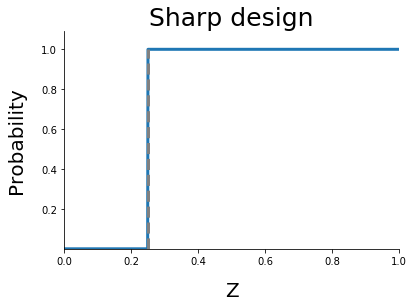

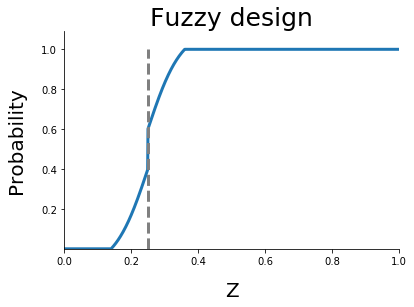

In [2]:
grid = np.linspace(0, 1.0, num=1000)
for version in ['sharp', 'fuzzy']:
    probs = get_treatment_probability(version, grid)
    get_plot_probability(version, grid, probs)

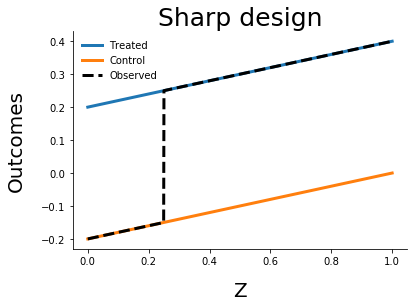

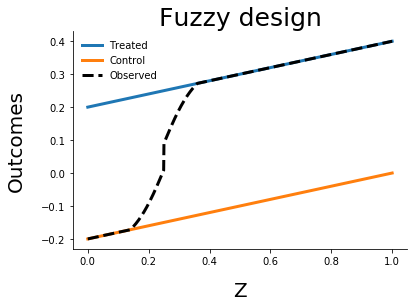

In [3]:
for version in ['sharp', 'fuzzy']:
    plot_outcomes(version, grid)

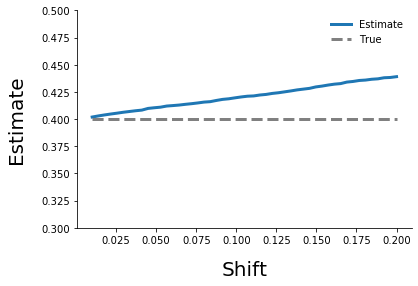

In [4]:
def get_potential_outcomes_new(grid):
    y1 = 0.2 + grid * 0.2
    y0 = -0.2 + grid * 0.2

    return y1, y0

import pandas as pd

columns = ['Y', 'D', 'Z']
index = pd.Index(range(1000), name='Identifier')
df = pd.DataFrame(columns=columns, index=index)

for i in range(1000):
    z = np.random.uniform()
    
    y1, y0 = get_potential_outcomes_new(z)
    
    if z > 0.25:
        d = 1
    else:
        d = 0
    
    y = d * y1 + (1 - d) * y0
    
    df.loc[i, :] = [y, d, z]
    
def get_average_effect(df, shift):
    control_subset = df['Z'].between(0.25 - shift, 0.25)
    treated_subset = df['Z'].between(0.25, 0.25 + shift)

    return df['Y'][treated_subset].mean() - df['Y'][control_subset].mean()

grid = np.linspace(0.01, 0.2)
rslt = list()
for shift in grid:
    rslt.append(get_average_effect(df, shift))
    
fig, ax = plt.subplots(1, 1)
ax.plot(grid, rslt, label='Estimate')
ax.set_ylim([0.3, 0.5])
ax.set_xlabel('Shift')
ax.set_ylabel('Estimate')

plt.plot(grid, [0.4] * 50, '--', color='grey', label='True')
ax.legend()

## Panel data

In [59]:
import pandas as pd
num_agents =  10000
columns = ['Y', 'D', 'O','X', 'E', 'U', 'Y_1', 'Y_0', 'Y_8']
index = list()
for i in range(num_agents):
    for j in [8, 9, 10]:
        index.append((i, j))
index = pd.MultiIndex.from_tuples(index, names=('Identifier', 'Grade'))
df = pd.DataFrame(columns=columns, index=index)

df.loc[(slice(None), 8), 'D'] =  0
df.head()

for i in range(num_agents):

    o = np.random.normal()
    e = np.random.normal()
    
    x = o + np.random.normal()
    u = o + np.random.normal()
    
    y0 = list()
    
    rslt = 98 + o + u + x + e + np.random.normal(scale=np.sqrt(10))
    y0.append(rslt)
    
    rslt = 99 + o + u + x + e + np.random.normal(scale=np.sqrt(10))
    y0.append(rslt)
 
    rslt = 100 + o + u + x + e + np.random.normal(scale=np.sqrt(10))
    y0.append(rslt)
 
    baseline_effect = np.random.normal(loc=9, scale=1)
    additional_effect = np.random.normal(loc=0, scale=1)
    
    y1 = list()
    
    rslt = -99.0
    y1.append(rslt)
    
    rslt = y0[1] + baseline_effect + additional_effect
    y1.append(rslt)
 
    rslt = y0[2] + (1 + baseline_effect) + additional_effect
    y1.append(rslt)
 
    
    def get_propensity_score(scenario, o, u, additional_effect, y0):
        
        if scenario == 'baseline':
            idx = -3.8 + o + u
        elif scenario == 'self-selection on gains':
            rslt = -7.3 + o + u + 5 * additional_effect
        elif scenario == 'positive self-selection on pretest':
            rslt = -3.8 + o + u + 0.05 * (y0[0] - 98)
        elif scenario == 'negative self-selection on pretest':
            rslt = -3.8 + o + u - 0.05 * (y0[0] - 98)
        else:
            raise NotImplementedError
            
        
        return np.exp(idx) / (1 + np.exp(idx))
    
    scenario = 'baseline'
    p = get_propensity_score(scenario, o, u, additional_effect, y0)
    
    d = np.random.choice([1, 0], p=[p, 1 -p])
    
    df.loc[(i, slice(None)), "Y_8"] = y0[0]
    
    df.loc[(i, 8), 'D'] = 0
    df.loc[(i, [9, 10]), 'D'] = d
    
    df.loc[(i, slice(None)), 'Y_1'] = y1
    df.loc[(i, slice(None)), 'Y_0'] = y0

    df.loc[(i, slice(None)), ['O', 'E', 'X', 'U']] = [o, e, x, u]
    
    df['Y'] = df['D'] * df['Y_1'] + (1 - df['D']) * df['Y_0']

    
df.head()

Y  D         O         X         E         U      Y_1  \
Identifier Grade                                                                
0          8      92.4894  0 -0.857053  -1.30957  0.428536 -0.634622      -99   
           9      101.504  0 -0.857053  -1.30957  0.428536 -0.634622  112.093   
           10     89.9822  0 -0.857053  -1.30957  0.428536 -0.634622   101.57   
1          8       100.11  0 -0.462658  0.525899  -1.05476  0.294559      -99   
           9      98.6073  0 -0.462658  0.525899  -1.05476  0.294559  108.842   

                      Y_0      Y_8  
Identifier Grade                    
0          8      92.4894  92.4894  
           9      101.504  92.4894  
           10     89.9822  92.4894  
1          8       100.11   100.11  
           9      98.6073   100.11

In [60]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
# Finally some type definitions for pretty output.
df = df.astype(np.float)
df = df.astype({'D': np.int})

subset = df.loc[(slice(None), 10), :]
rslt = smf.ols(formula='Y ~ D', data=subset).fit()
print(rslt.params['D'])

subset.loc[(slice(None), slice(None)), 'S'] = subset['Y'] - subset['Y_8']
rslt = smf.ols(formula='S ~ D ', data=subset).fit()
print(rslt.params['D'])

rslt = smf.ols(formula='Y ~ D + Y_8 + O + U', data=subset).fit()
print(rslt.params['D'])

14.605624554729182
9.866914237854683
9.789659986655225


/home/peisenha/.local/share/anaconda3/envs/teaching_microeconometrics/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


## References

* https://www.innovations.harvard.edu/sites/default/files/Braga_problem_oriented%20policing_deterrence.pdf

